In [1]:
# Import packages
!pip install imbalanced-learn==0.12.0 --no-deps --quiet
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import os
import time
import kagglehub
from kagglehub import KaggleDatasetAdapter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.1 MB/s eta 0:00:0000:01


# Data Collection

In [2]:
# Download dataset
kagglehub.dataset_download('madhavmalhotra/unb-cic-iot-dataset')

In [3]:
DIR_PATH = "/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023"

# Get a list of all .csv files from the directory (total .csv files = 169)
csv_files = [f for f in os.listdir(DIR_PATH) if f.endswith('.csv')]

# Sort based on file number
csv_files.sort() 

# Load only the first 20 files due to limited processing power (Comment the line below to load all files)
csv_files = csv_files[:20]  

In [4]:
# Load and concatenate all files into a list of DataFrame objects
all_dfs = []

for file in csv_files:
    file_path = "wataiData/csv/CICIoT2023/" + file    
    df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "madhavmalhotra/unb-cic-iot-dataset",
        file_path
    )        
    all_dfs.append(df)

# Verify number of DataFrames
print("DataFrames loaded:", len(all_dfs))

DataFrames loaded: 20


In [5]:
# Combine all DataFrames into a single DataFrame
main_df = pd.concat(all_dfs, ignore_index=True) 

# Add new column for label with binary value (1 for DoS attacks, 0 for other attacks/normal traffic)
main_df['binary_label'] = main_df['label'].apply(lambda x: 1 if str(x).startswith('DoS') else 0)

# Rows and columns of the dataset 
print("Rows: {}, Columns: {}".format(main_df.shape[0], main_df.shape[1]))

Rows: 4723822, Columns: 48


# Data Overview

In [6]:
# Summary of the dataset
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723822 entries, 0 to 4723821
Data columns (total 48 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   Header_Length    float64
 2   Protocol Type    float64
 3   Duration         float64
 4   Rate             float64
 5   Srate            float64
 6   Drate            float64
 7   fin_flag_number  float64
 8   syn_flag_number  float64
 9   rst_flag_number  float64
 10  psh_flag_number  float64
 11  ack_flag_number  float64
 12  ece_flag_number  float64
 13  cwr_flag_number  float64
 14  ack_count        float64
 15  syn_count        float64
 16  fin_count        float64
 17  urg_count        float64
 18  rst_count        float64
 19  HTTP             float64
 20  HTTPS            float64
 21  DNS              float64
 22  Telnet           float64
 23  SMTP             float64
 24  SSH              float64
 25  IRC              float64
 26  TCP              float64
 27  UDP         

In [7]:
# Summary statistics
main_df.describe()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,binary_label
count,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,...,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06,4.723822e+06
mean,5.653122e+00,7.698439e+04,9.063203e+00,6.636259e+01,9.042533e+03,9.042533e+03,3.370429e-06,8.648844e-02,2.070334e-01,9.040476e-02,...,3.344026e+01,1.247858e+02,8.318028e+07,9.498367e+00,1.312610e+01,4.725837e+01,3.098479e+04,9.654789e-02,1.415096e+02,1.730734e-01
std,2.711109e+02,4.619563e+05,8.939536e+00,1.407410e+01,9.987315e+04,9.987315e+04,1.968103e-03,2.810840e-01,4.051797e-01,2.867608e-01,...,1.609869e+02,2.419551e+02,1.705561e+07,8.196692e-01,8.636352e+00,2.276906e+02,3.355116e+05,2.331664e-01,2.107998e+01,3.783108e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.200000e+01,0.000000e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,2.092557e+00,2.092557e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.000000e+01,8.307157e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,0.000000e+00
50%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,1.575915e+01,1.575915e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.400000e+01,8.312452e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,0.000000e+00
75%,1.048759e-01,2.913200e+02,1.433000e+01,6.400000e+01,1.173987e+02,1.173987e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.719096e-01,5.406000e+01,8.334390e+07,9.500000e+00,1.039673e+01,5.059213e-01,1.344216e+00,8.000000e-02,1.415500e+02,0.000000e+00
max,9.943576e+04,9.889368e+06,4.700000e+01,2.550000e+02,8.388608e+06,8.388608e+06,2.679210e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.099626e+04,1.309800e+04,1.676394e+08,1.500000e+01,1.453904e+02,1.555106e+04,1.372844e+08,1.000000e+00,2.446000e+02,1.000000e+00


In [8]:
# First 5 records
print(main_df.head())

   flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0       0.000000          54.00           6.00     64.00     0.329807   
1       0.000000          57.04           6.33     64.00     4.290556   
2       0.000000           0.00           1.00     64.00    33.396799   
3       0.328175       76175.00          17.00     64.00  4642.133010   
4       0.117320         101.73           6.11     65.91     6.202211   

         Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0     0.329807    0.0              1.0              0.0              1.0  ...   
1     4.290556    0.0              0.0              0.0              0.0  ...   
2    33.396799    0.0              0.0              0.0              0.0  ...   
3  4642.133010    0.0              0.0              0.0              0.0  ...   
4     6.202211    0.0              0.0              1.0              0.0  ...   

   Tot size           IAT  Number   Magnitue     Radius   Covariance  \
0 

In [9]:
# Identify all textual (non-numeric) columns
text_col = main_df.select_dtypes(include=['object','category']).columns
print(text_col.to_list())

['label']


In [10]:
# Identify all numeric columns
num_col = main_df.select_dtypes(include=['float64','int64']).columns
print(num_col.to_list())

['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'binary_label']


In [11]:
# Number of rows for top 15 label categories
label_counts = main_df['label'].value_counts().head(15)
print(label_counts, "\n")

label
DDoS-ICMP_Flood            728930
DDoS-UDP_Flood             547498
DDoS-TCP_Flood             455747
DDoS-PSHACK_Flood          414628
DDoS-SYN_Flood             411434
DDoS-RSTFINFlood           408875
DDoS-SynonymousIP_Flood    363311
DoS-UDP_Flood              336005
DoS-TCP_Flood              270249
DoS-SYN_Flood              204010
BenignTraffic              111208
Mirai-greeth_flood          99640
Mirai-udpplain              90310
Mirai-greip_flood           76356
DDoS-ICMP_Fragmentation     45709
Name: count, dtype: int64 



label
DoS-UDP_Flood     336005
DoS-TCP_Flood     270249
DoS-SYN_Flood     204010
DoS-HTTP_Flood      7304
Name: count, dtype: int64 



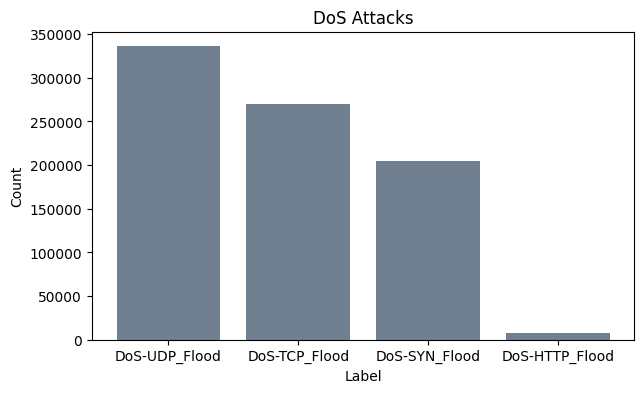

In [12]:
# Number of rows for each DoS attack category
dos_df = main_df[main_df['label'].str.startswith('DoS', na=False)]
dos_counts = dos_df['label'].value_counts()
print(dos_counts, "\n")

# Visualize with bar chart
plt.figure(figsize=(7, 4))
plt.bar(dos_counts.index, dos_counts.values, color='slategray')
plt.title("DoS Attacks")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

binary_label
Non-DoS    3906254
DoS         817568
Name: count, dtype: int64 



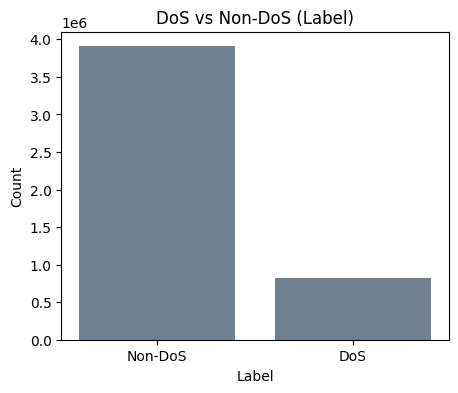

In [13]:
# Number of rows for DoS and non-DoS data
bin_label_df = main_df.binary_label.apply(lambda x: 'DoS' if x==1 else 'Non-DoS')
bin_label_counts = bin_label_df.value_counts()
print(bin_label_counts, "\n")

# Visualize with bar chart
plt.figure(figsize=(5, 4))
plt.bar(bin_label_counts.index, bin_label_counts.values, color='slategray')
plt.title("DoS vs Non-DoS (Label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Data Preprocessing

In [14]:
# This column is redundant and gives no useful information
main_df.drop('Protocol Type', axis=1, inplace=True)
print("Remaining columns: {}".format(main_df.shape[1]))

Remaining columns: 47


## Handle Missing/Unique Data

In [15]:
# Identify columns with missing values
col_missing = main_df.isnull().sum()
col_missing = col_missing[col_missing > 0]

if len(col_missing) != 0:
    print("Columns with missing values:\n", col_missing)
else:
    print("No column with missing values found.")

No column with missing values found.


In [16]:
# Calculate the quantity and percentage of missing values for each column, sorted from most to least
missing_counts = main_df.isnull().sum()
total_missing = missing_counts.sort_values(ascending=False)
percent_missing = (missing_counts / len(main_df) * 100).sort_values(ascending=False)

# Display top 5 columns with the most missing values
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total_Missing', 'Percent(%)'])
missing_data['Percent(%)'] = missing_data['Percent(%)'].round(2)
missing_data.head()

,Total_Missing,Percent(%)
flow_duration,0,0.0
AVG,0,0.0
UDP,0,0.0
DHCP,0,0.0
ARP,0,0.0


In [17]:
# Determine number of unique values for each feature
uq_one, uq_all, output = [], [], []
print("Max unique values: {}".format(main_df.shape[0]))
print("\nUnique values in each column:\n\
----------------------------")

for col in main_df.columns:
    num_uq = len(main_df[col].unique())
    output.append("{}={}".format(col, num_uq)) 

    # Check for columns with only single unique value, or all values are unique
    if num_uq == 1: 
        uq_one.append(col)
    elif num_uq == main_df.shape[0]:
        uq_all.append(col)        

print(output)

Max unique values: 4723822

Unique values in each column:
----------------------------
['flow_duration=2126144', 'Header_Length=608836', 'Duration=11597', 'Rate=3211424', 'Srate=3211424', 'Drate=269', 'fin_flag_number=2', 'syn_flag_number=2', 'rst_flag_number=2', 'psh_flag_number=2', 'ack_flag_number=2', 'ece_flag_number=2', 'cwr_flag_number=2', 'ack_count=428', 'syn_count=1218', 'fin_count=723', 'urg_count=19199', 'rst_count=47072', 'HTTP=2', 'HTTPS=2', 'DNS=2', 'Telnet=1', 'SMTP=1', 'SSH=2', 'IRC=1', 'TCP=2', 'UDP=2', 'DHCP=2', 'ARP=2', 'ICMP=2', 'IPv=2', 'LLC=2', 'Tot sum=251261', 'Min=50502', 'Max=76722', 'AVG=683047', 'Std=649323', 'Tot size=70022', 'IAT=4703093', 'Number=96', 'Magnitue=671018', 'Radius=627259', 'Covariance=630068', 'Variance=789', 'Weight=102', 'label=34', 'binary_label=2']


In [18]:
original_df = main_df.copy()  # copy for backup
ori_col = main_df.shape[1]
flag = False

# Drop columns with only 1 unique value - no variance
if len(uq_one) > 0:
    print("Dropping {} columns with a single unique value:\n\t{}".format(len(uq_one), uq_one))
    main_df.drop(uq_one, axis=1, inplace=True)
    flag = True
    
# Drop columns with all unique values - no pattern, may lead to overfitting
if len(uq_all) > 0:
    print("Dropping {} columns with all unique values:\n\t{}".format(len(uq_all), uq_all))
    main_df.drop(uq_all, axis=1, inplace=True)
    flag = True

if flag: 
    print("\nOriginal number of columns:", ori_col)
    print("Current number of columns:", main_df.shape[1])
else:
    print("No columns are dropped.")

Dropping 3 columns with a single unique value:
	['Telnet', 'SMTP', 'IRC']

Original number of columns: 47
Current number of columns: 44


In [19]:
# Drop rows with missing label
if main_df['label'].isnull().any():
    ori_rows = main_df.shape[0]
    main_df = main_df[main_df['label'].notnull()]    
    curr_rows = main_df.shape[0]
    no_del_rows = ori_rows - curr_rows
    print(f"{no_del_rows} rows with missing labels are dropped.")
else:
    print("No rows with missing labels.")

No rows with missing labels.


In [20]:
# If there are missing values, fill with mean value
if main_df.isnull().values.any():
    main_df.fillna(main_df.mean(numeric_only=True), inplace=True)
    print("Missing data has been replaced with the mean value.")
else:
    print("No missing data found.")

No missing data found.


## Train-Test Split

In [21]:
from sklearn.model_selection import train_test_split

# Features and label for binary classification (DoS vs non-DoS)
pre_X = main_df.drop(columns=['label', 'binary_label'])
pre_y = main_df[['label','binary_label']]

# Split into train & test sets (80% training, 20% testing)
pre_X_train, pre_X_test, pre_y_train, pre_y_test = train_test_split(pre_X, pre_y,
                                                                    test_size=0.2,
                                                                    random_state=30,
                                                                    stratify=pre_y)
# Reset row indices for 0-based indices after splitting
for df in [pre_X_train, pre_X_test, pre_y_train, pre_y_test]:
    df.reset_index(drop=True, inplace=True)

In [22]:
# Dimensions of training and testing set
print('Features_Training: {} rows, {} columns'.format(pre_X_train.shape[0], pre_X_train.shape[1]))
print('Features_Testing:  {} rows, {} columns'.format(pre_X_test.shape[0], pre_X_test.shape[1]))
print('\nLabel_Training: {:>10} rows, {} columns'.format(pre_y_train.shape[0], pre_y_train.shape[1]))
print('Label_Testing: {:>10} rows, {} columns'.format(pre_y_test.shape[0], pre_y_test.shape[1]))

Features_Training: 3779057 rows, 42 columns
Features_Testing:  944765 rows, 42 columns

Label_Training:    3779057 rows, 2 columns
Label_Testing:     944765 rows, 2 columns


In [23]:
# Distribution of labels in training and testing sets
def get_label_distribution(y, name):
    total = len(y)
    dist = y.value_counts().sort_index()
    df = pd.DataFrame({
        'Frequency': dist,
        'Percentage(%)': (dist / total * 100).round(2)
    })
    print(f"Total labels in {name} set: {total}")
    print(df, "\n")

get_label_distribution(pre_y_train['binary_label'], "Training")
get_label_distribution(pre_y_test['binary_label'], "Testing")

Total labels in Training set: 3779057
              Frequency  Percentage(%)
binary_label                          
0               3125003          82.69
1                654054          17.31 

Total labels in Testing set: 944765
              Frequency  Percentage(%)
binary_label                          
0                781251          82.69
1                163514          17.31 



## Class Balancing

### Upsample DoS Attack in Training Set
> Synthetic Minority Oversampling Technique (SMOTE) is a technique used to address class imbalance by generating artificial samples for the minority class.

In [24]:
# Mean of DoS labels
dos_mean = pre_y_train['label'][pre_y_train['label'].str.startswith('DoS')].value_counts().mean()

# Upsample DoS-HTTP_Flood since its severely underrepresented
http_upsample = int(dos_mean / 2)

# Apply SMOTE to upsample HTTP flood 
smote = SMOTE(sampling_strategy={'DoS-HTTP_Flood': http_upsample}, random_state=30)
X_train_smote, y_train_smote = smote.fit_resample(pre_X_train, pre_y_train['label'])

# Check class distribution for DoS attacks before and after upsampling
dos_labels_before = pre_y_train['label'][pre_y_train['label'].str.startswith('DoS')]
print("Before SMOTE (DoS only):")
print(dos_labels_before.value_counts())

dos_labels_after = y_train_smote[y_train_smote.str.startswith('DoS')]
print("\nAfter SMOTE (DoS only):")
print(dos_labels_after.value_counts())

Before SMOTE (DoS only):
label
DoS-UDP_Flood     268804
DoS-TCP_Flood     216199
DoS-SYN_Flood     163208
DoS-HTTP_Flood      5843
Name: count, dtype: int64

After SMOTE (DoS only):
label
DoS-UDP_Flood     268804
DoS-TCP_Flood     216199
DoS-SYN_Flood     163208
DoS-HTTP_Flood     81756
Name: count, dtype: int64


In [25]:
# Add binary label column for upsampled data
y_train_smote_df = pd.DataFrame(y_train_smote, columns=['label'])
y_train_smote_df['binary_label'] = y_train_smote_df['label'].apply(lambda x: 1 if x.startswith('DoS') else 0)

# Combine the upsampled data into a new Dataframe
train_df = pd.concat([X_train_smote, y_train_smote_df], axis=1)

### Downsample Non-DoS Samples in Training Set

In [26]:
print("Distribution before downsampling:\n", train_df['binary_label'].value_counts()) 

# Separate classes
non_dos = train_df[train_df['binary_label'] == 0]
dos = train_df[train_df['binary_label'] == 1]

# Downsample Non-DoS to match DoS count
non_dos_downsampled = resample(non_dos, 
                               replace=False, 
                               n_samples=len(dos), 
                               random_state=30)

# Combine balanced training set
train_balanced_df = pd.concat([dos, non_dos_downsampled])

# Shuffle after concatenation (so DoS/non-DoS will not be grouped together)
train_balanced_df = train_balanced_df.sample(frac=1, random_state=30).reset_index(drop=True)
print("\nDistribution after downsampling:\n", train_balanced_df['binary_label'].value_counts()) 

Distribution before downsampling:
 binary_label
0    3125003
1     729967
Name: count, dtype: int64

Distribution after downsampling:
 binary_label
0    729967
1    729967
Name: count, dtype: int64


### Split resampled data and dropping zero-variance features

In [27]:
from sklearn.feature_selection import VarianceThreshold

# Split back into balanced training & testing sets
pre_X_train_balanced = train_balanced_df.drop(columns=['label', 'binary_label'])
pre_y_train_balanced = train_balanced_df['binary_label']

# Drop features with zero variance after resampling
selector = VarianceThreshold(threshold=0.0)
selector.fit_transform(pre_X_train_balanced)

# Determine what features are dropped
mask = selector.get_support()
all_features = pre_X_train_balanced.columns
removed_features = all_features[~mask]

if len(removed_features) > 0:
    pre_X_train_balanced.drop(columns=removed_features, inplace=True)
    print(f"{len(removed_features)} zero-variance feature(s) dropped:\n", removed_features.tolist())        
else:
    print("No feature is dropped.")

1 zero-variance feature(s) dropped:
 ['cwr_flag_number']


# Feature Selection

In [28]:
# Features and label dataframe for feature extraction
features_df = pre_X_train_balanced.copy()
label_df = pre_y_train_balanced.copy()

print(f"(Features Training Set) Rows: {features_df.shape[0]}, Columns: {features_df.shape[1]}")
print(f"(Label Training Set) Rows: {label_df.shape[0]}")

(Features Training Set) Rows: 1459934, Columns: 41
(Label Training Set) Rows: 1459934


## Pearson Correlation (r)
> A number between -1 and 1. <br>
> Measures the strength and direction of linear relationship between two variables.<br>
> When the number is closer to 0, it indicates a weaker linear relationship.

### Pearson Correlation of a feature with other features

In [29]:
# Calculate Pearson correlation coefficients for all features, excluding the label
corr_matrix = features_df.corr().round(2);

In [30]:
# Filter very strong Pearson correlations (>= 0.9 or <= -0.9)
strong_corr = corr_matrix[(corr_matrix >= 0.9) | (corr_matrix <= -0.9)]

# Remove self correlation (1.0 on diagonal)
np.fill_diagonal(strong_corr.values, 0)

# Extract feature pairs with strong correlations
strong_pairs = []
strong_features = set()

for i in range(len(strong_corr.columns)):
    for j in range(i+1, len(strong_corr.columns)): # i+1 to avoid duplicates
        val = strong_corr.iloc[i, j]
        if abs(val) >= 0.9:                
            feature_1 = strong_corr.columns[i]
            feature_2 = strong_corr.columns[j]
            strong_pairs.append((feature_1, feature_2, val)) 
            # Add unique features to the set
            strong_features.add(feature_1)
            strong_features.add(feature_2)

strong_features = list(strong_features)
print(f"There are {len(strong_pairs)} feature pairs with very strong correlations (r >= 0.9 or r <= -0.9).")
print(f"\nFeatures that have very strong correlation with at least 1 other feature (Total={len(strong_features)}):\n\n" \
      + str(strong_features))

There are 15 feature pairs with very strong correlations (r >= 0.9 or r <= -0.9).

Features that have very strong correlation with at least 1 other feature (Total=16):

['IPv', 'Magnitue', 'Srate', 'ack_count', 'Std', 'Weight', 'Rate', 'Radius', 'Number', 'Tot size', 'AVG', 'fin_flag_number', 'IAT', 'Tot sum', 'Max', 'LLC']


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


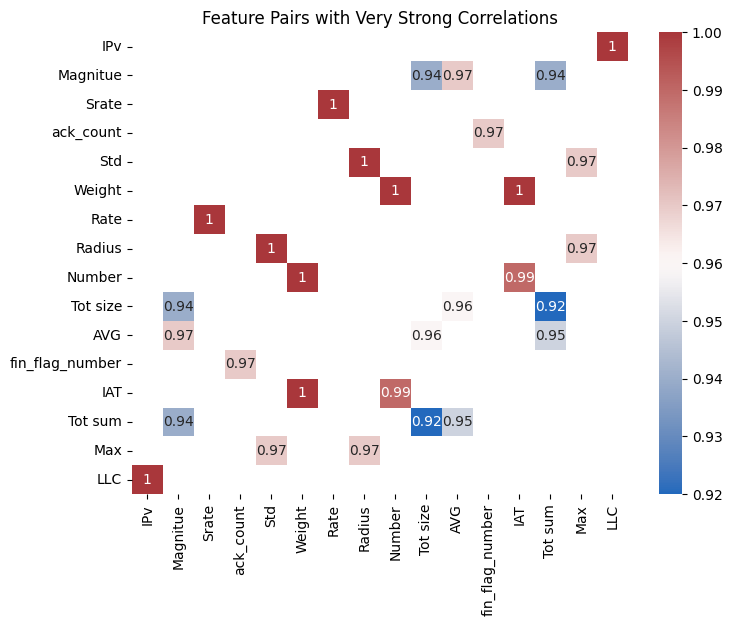

In [31]:
# Visualize feature pairs with very strong correlations
heatmap_data = pd.DataFrame(index=strong_features, columns=strong_features, data=np.nan)

for f1, f2, val in strong_pairs:
    heatmap_data.loc[f1, f2] = val
    heatmap_data.loc[f2, f1] = val

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="vlag")
plt.title("Feature Pairs with Very Strong Correlations")
plt.show()

In [32]:
# Filter weak Pearson correlations (-0.1 < r < 0.1)
weak_corr = corr_matrix[(corr_matrix < 0.1) & (corr_matrix > -0.1)]

# Remove self correlation (1.0 on diagonal)
np.fill_diagonal(weak_corr.values, np.nan)

# Extract feature pairs with weak correlations
weak_pairs = []
weak_features = set()

for i in range(len(weak_corr.columns)):
    for j in range(i+1, len(weak_corr.columns)): # i+1 to avoid duplicates
        val = weak_corr.iloc[i, j]
        if not np.isnan(val):                    
            feature_1 = weak_corr.columns[i]
            feature_2 = weak_corr.columns[j]
            weak_pairs.append((feature_1, feature_2, val))
            # Add unique features to the set
            weak_features.add(feature_1)
            weak_features.add(feature_2)

weak_features = list(weak_features)
print(f"There are {len(weak_pairs)} feature pairs with weak correlations (-0.1 < r < 0.1).\n")
print(f"Features that have weak correlation with at least 1 other feature (Total={len(weak_features)}):\n\n" \
      + str(weak_features))

There are 591 feature pairs with weak correlations (-0.1 < r < 0.1).

Features that have weak correlation with at least 1 other feature (Total=41):

['urg_count', 'Weight', 'ack_count', 'HTTP', 'Number', 'AVG', 'IPv', 'rst_flag_number', 'flow_duration', 'syn_count', 'Magnitue', 'Srate', 'Std', 'UDP', 'fin_flag_number', 'Duration', 'ece_flag_number', 'HTTPS', 'LLC', 'Header_Length', 'Drate', 'fin_count', 'syn_flag_number', 'Rate', 'DNS', 'Radius', 'Tot size', 'ARP', 'Tot sum', 'Min', 'Max', 'Variance', 'Covariance', 'DHCP', 'ack_flag_number', 'SSH', 'TCP', 'psh_flag_number', 'rst_count', 'ICMP', 'IAT']


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


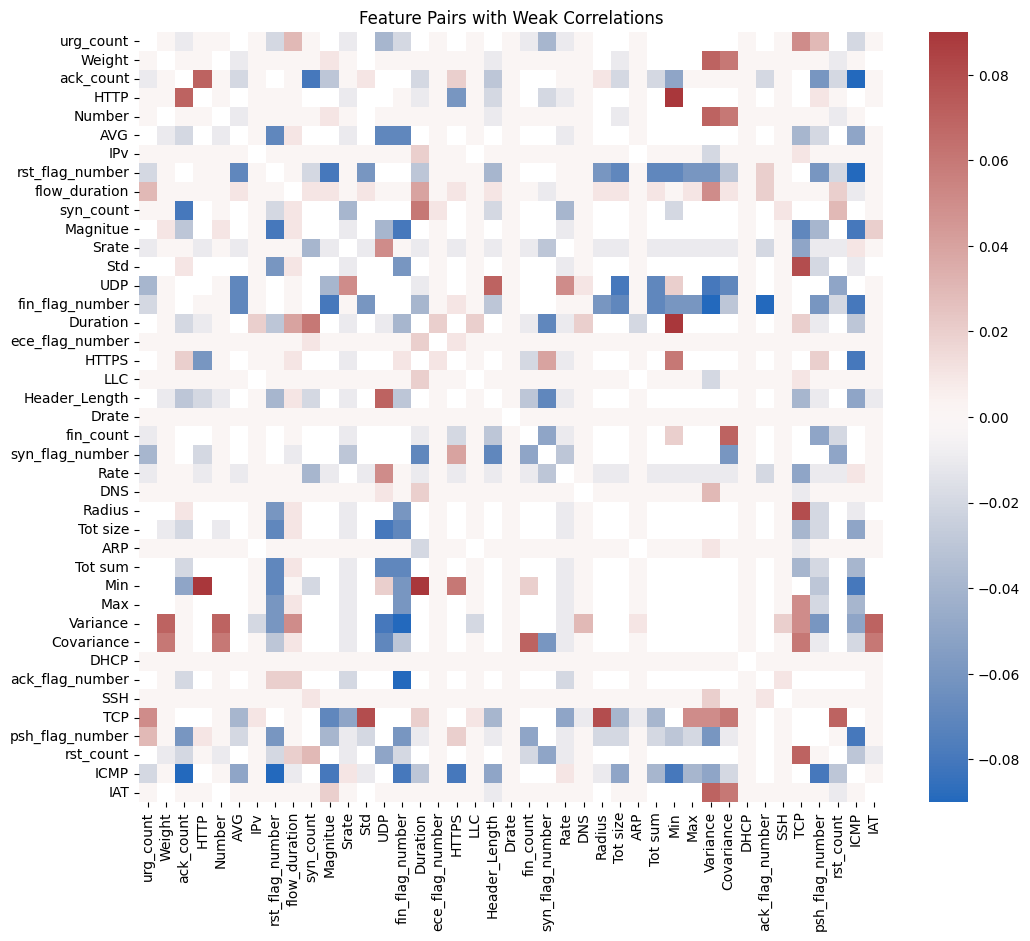

In [33]:
# Visualize feature pairs with weak correlations
heatmap_data = pd.DataFrame(index=weak_features, columns=weak_features, data=np.nan)

for f1, f2, val in weak_pairs:
    heatmap_data.loc[f1, f2] = val
    heatmap_data.loc[f2, f1] = val

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="vlag", annot=False)
plt.title("Feature Pairs with Weak Correlations")
plt.show()

### Pearson Correlation of each feature with the label

In [34]:
# Calculate Pearson correlation between each feature and the binary label
correlations = {}

for feature in features_df.columns:
    corr_val = features_df[feature].corr(label_df)
    correlations[feature] = corr_val

# Convert results to DataFrame 
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])

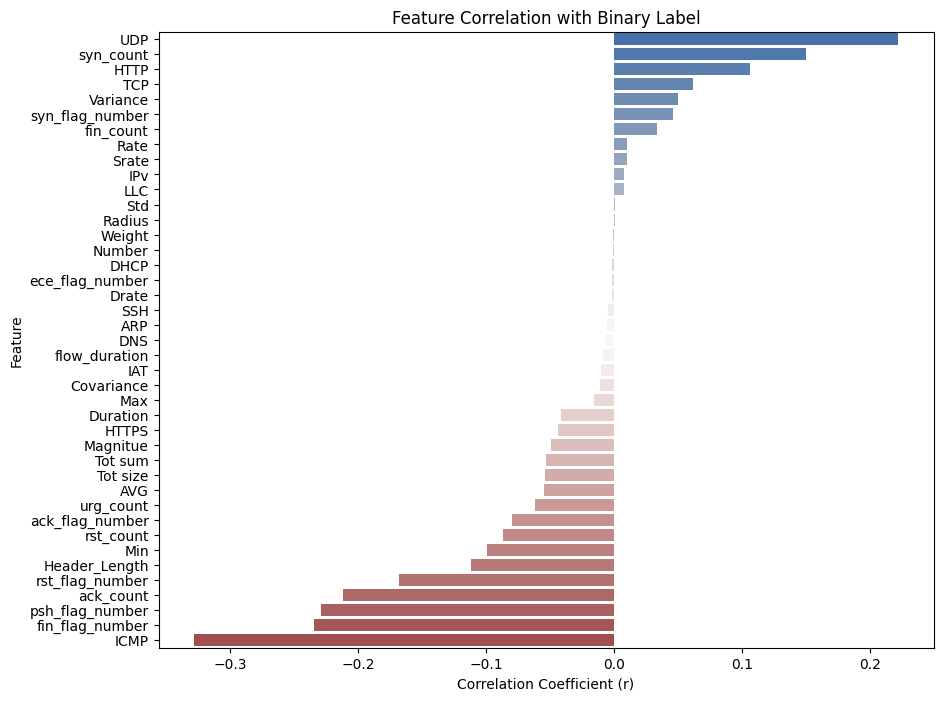

In [35]:
# Visualize feature correlation with binary label 
corr_sorted = corr_df.sort_values('Correlation', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Correlation', y=corr_sorted.index, data=corr_sorted, palette='vlag')
plt.title('Feature Correlation with Binary Label')
plt.xlabel('Correlation Coefficient (r)')
plt.ylabel('Feature')
plt.show()

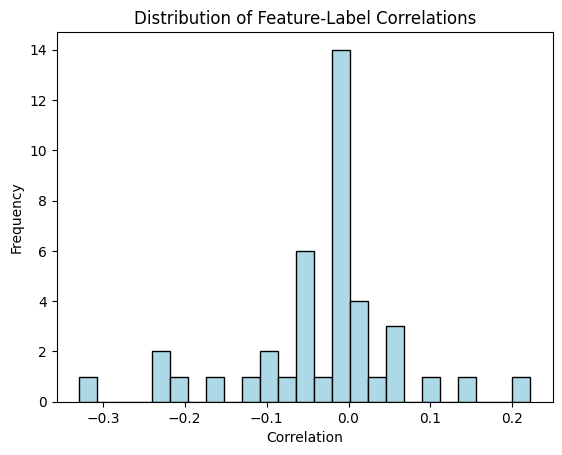

In [36]:
# Visualize distribution of feature correlation with binary label 
plt.hist(corr_df['Correlation'], bins=25, color='lightblue', edgecolor='black')
plt.title('Distribution of Feature-Label Correlations')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

In [37]:
#  Identify features moderately correlated to the label (r >= 0.4 or r <= -0.4)
threshold = 0.4
moderate_features_lb = []

for feature, corr_val in corr_df['Correlation'].items():
    if abs(corr_val) >= threshold:
        moderate_features_lb.append(feature)

print(f"Features that have moderate correlation with the label (Total={len(moderate_features_lb)}):\n\n" \
      + str(moderate_features_lb))

Features that have moderate correlation with the label (Total=0):

[]


In [38]:
# Visualize features moderately correlated to the label 
mod_corr_df = corr_df[abs(corr_df['Correlation']) >= threshold]

if not mod_corr_df.empty:
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Correlation', y=mod_corr_df.index, data=mod_corr_df, palette='coolwarm')
    plt.title('Features Moderately Correlated with Binary Label')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.show()
else:
    print("No features have moderate correlation with the binary label.")

No features have moderate correlation with the binary label.


In [39]:
# Identify features weakly correlated to the label (-0.1 < r < 0.1)
threshold2 = 0.1
weak_features_lb = []

for feature, corr_val in corr_df['Correlation'].items():
    if abs(corr_val) < threshold2:
        weak_features_lb.append(feature)

print(f"Features that have weak correlation with the label (Total={len(weak_features_lb)}):\n\n" \
      + str(weak_features_lb))

Features that have weak correlation with the label (Total=32):

['flow_duration', 'Duration', 'Rate', 'Srate', 'Drate', 'syn_flag_number', 'ack_flag_number', 'ece_flag_number', 'fin_count', 'urg_count', 'rst_count', 'HTTPS', 'DNS', 'SSH', 'TCP', 'DHCP', 'ARP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']


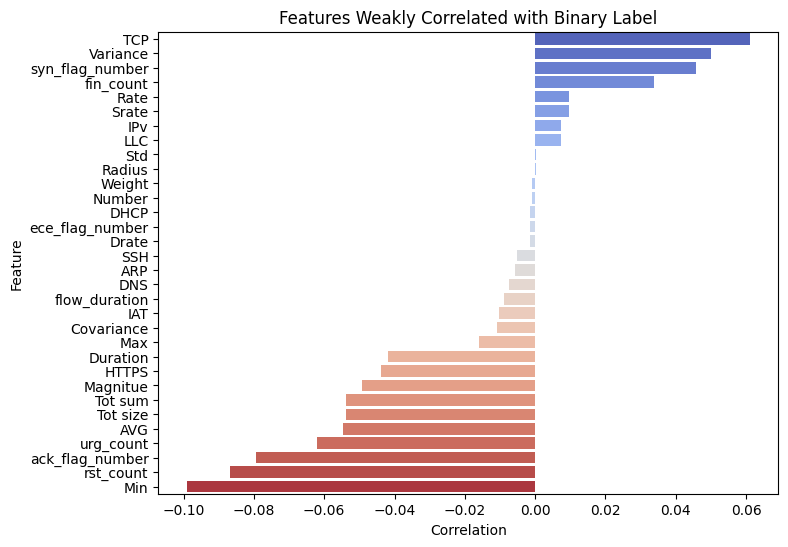

In [40]:
# Visualize features weakly correlated to the label 
weak_corr_df = corr_df[abs(corr_df['Correlation']) < threshold2]
weak_corr_df = weak_corr_df.sort_values(by='Correlation', ascending=False)

if not weak_corr_df.empty:
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Correlation', y=weak_corr_df.index, data=weak_corr_df, palette='coolwarm')
    plt.title('Features Weakly Correlated with Binary Label')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.show()
else:
    print("No features have weak correlation with the binary label.")

## Mutual Information (MI)
> Measures how useful a variable X is a predicting a random variable Y. <br>
> A higher MI score means the feature is more useful for prediction.<br>
> Can capture many types of relationships (not just linear).

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

# Scale features for faster computation time
scaler = MinMaxScaler()  
scaled_features = features_df.copy()

cols = features_df.columns
scaled_features[cols] = scaler.fit_transform(scaled_features[cols])

# Calculate MI scores between each feature and the label
mi_scores = mutual_info_classif(scaled_features, label_df, discrete_features=False, random_state=30)

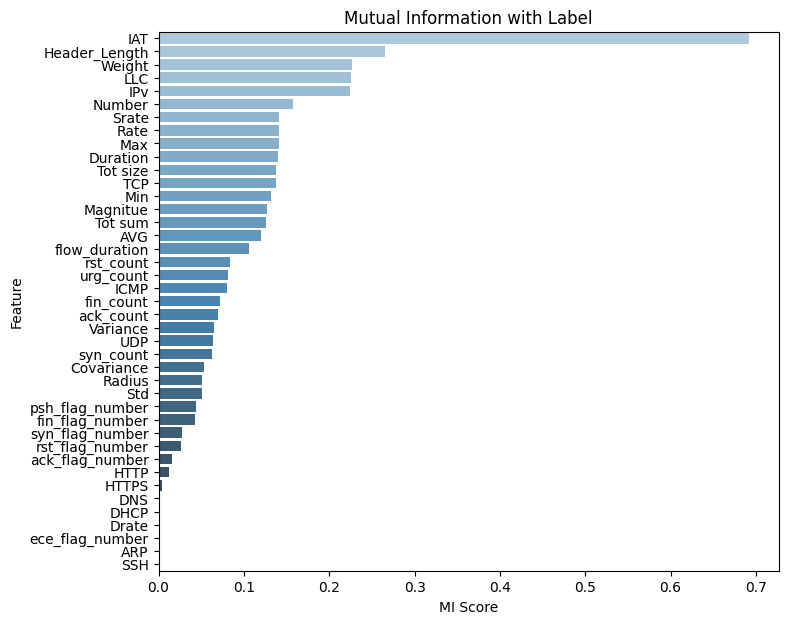

In [42]:
# Visualize the MI scores between each feature and the label
mi_df = pd.DataFrame({
    "Feature": features_df.columns,
    "MI Score": mi_scores
})
mi_df = mi_df.sort_values("MI Score", ascending=False)

plt.figure(figsize=(8, 7))
sns.barplot(x="MI Score", y="Feature", data=mi_df, palette="Blues_d").set(
    title="Mutual Information with Label")
plt.show()

In [43]:
# Identify the top 25 features with the highest MI score
top_mi_features = mi_df['Feature'].head(25).tolist()
print(top_mi_features)

['IAT', 'Header_Length', 'Weight', 'LLC', 'IPv', 'Number', 'Srate', 'Rate', 'Max', 'Duration', 'Tot size', 'TCP', 'Min', 'Magnitue', 'Tot sum', 'AVG', 'flow_duration', 'rst_count', 'urg_count', 'ICMP', 'fin_count', 'ack_count', 'Variance', 'UDP', 'syn_count']


## Feature Importance

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Assigns importance value to each feature, based on tree-based model (random forest)
rf = RandomForestClassifier(max_depth=5, random_state=30)

# Select features with importance value greater than the median (top 50%)
selector = SelectFromModel(estimator=rf, threshold='median')  

# Fit and transform training sets of features and label
select_features = features_df.copy()
select_label = label_df.copy()
selector.fit_transform(select_features, select_label)

# Identify features selected
rf_features = select_features.columns[selector.get_support()].tolist()
print(f"Selected features (Total={len(rf_features)}):\n{rf_features}")

Selected features (Total=21):
['flow_duration', 'Header_Length', 'Rate', 'Srate', 'fin_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_count', 'fin_count', 'urg_count', 'rst_count', 'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Tot size', 'IAT', 'Magnitue', 'Variance']


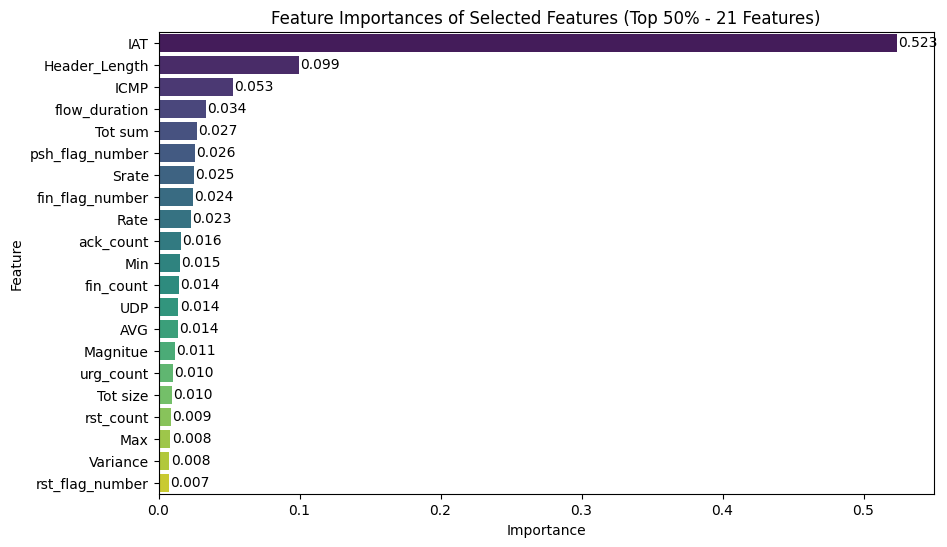

In [45]:
# Get feature importances from the fitted model
importances = selector.estimator_.feature_importances_

# Create DataFrame of selected features and their importances
selected_mask = selector.get_support()
selected_rf_features = select_features.columns[selected_mask]
selected_rf_importances = importances[selected_mask]

feature_imp_df = pd.DataFrame({
    'Feature': selected_rf_features,
    'Importance': selected_rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title(f'Feature Importances of Selected Features (Top 50% - {len(selected_rf_features)} Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add value labels
for idx, val in enumerate(feature_imp_df['Importance']):
    plt.text(val + 0.001, idx, f"{val:.3f}", va='center')
plt.show()

## Removing Irrelevant Features
> Filter based on Pearson correlation coefficients, MI scores, feature importance

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

def print_cv_metrics(scores):
    print("Mean Accuracy:", round(scores['test_accuracy'].mean(), 3))
    print("Mean Precision:", round(scores['test_precision'].mean(), 3))
    print("Mean Recall:", round(scores['test_recall'].mean(), 3))
    print("Mean F1-score:", round(scores['test_f1'].mean(), 3))

# Use simple LogisticRegression model to compare performances between full/reduced features of training sets 
# to determine if dropping features is justified
model = LogisticRegression(C=0.1, max_iter=500, random_state=30)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']

# Performance metrics - all features  
start_time = time.time()
pre_scores = cross_validate(model, scaled_features, label_df, cv=3, scoring=scoring_metrics)

print("Performance Before Feature Reduction:\n")
print("Time taken(s):", round(time.time() - start_time, 2))
print_cv_metrics(pre_scores)

Performance Before Feature Reduction:

Time taken(s): 193.27
Mean Accuracy: 0.761
Mean Precision: 0.705
Mean Recall: 0.897
Mean F1-score: 0.79


In [47]:
# Decide which feature to drop based on correlation, MI, and feature importance
final_features_df = features_df.copy()
miss_both = set()
collinear = set() 

# Drop feature if its missing from both top MI score and importance list
for feature in final_features_df.columns:        
    if feature not in top_mi_features and feature not in rf_features:
        miss_both.add(feature)
        
# For features that have high collinearity with another feature, drop the less important one (lower MI score)
feature_mi = dict(zip(mi_df['Feature'], mi_df['MI Score'])) 
for f1, f2, _ in strong_pairs:
    if f1 not in collinear and f2 not in collinear:                
        if feature_mi.get(f1, 0) >= feature_mi.get(f2, 0):
            collinear.add(f2)
        else:
            collinear.add(f1)  

In [48]:
print("Total features before dropping:", len(final_features_df.columns))

# Drop features from the dataframe
drop_features = miss_both.union(collinear)
final_features_df.drop(columns=drop_features, inplace=True)

print(f"Total features to drop: {len(drop_features)}\n")
print(f"\t({len(miss_both)} features) Missing from both top MI score and feature importance list:\n\t{miss_both}\n")
print(f"\t({len(collinear)} features) High collinearity with another feature:\n\t{collinear}")

print(f"\nRemaining features: {len(final_features_df.columns)}")
print(final_features_df.columns.tolist())

Total features before dropping: 41
Total features to drop: 21

	(13 features) Missing from both top MI score and feature importance list:
	{'Drate', 'Covariance', 'DHCP', 'ack_flag_number', 'syn_flag_number', 'Std', 'HTTP', 'DNS', 'SSH', 'Radius', 'ARP', 'ece_flag_number', 'HTTPS'}

	(10 features) High collinearity with another feature:
	{'IPv', 'Magnitue', 'Weight', 'Std', 'Rate', 'Radius', 'Number', 'AVG', 'fin_flag_number', 'Tot sum'}

Remaining features: 20
['flow_duration', 'Header_Length', 'Duration', 'Srate', 'rst_flag_number', 'psh_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'TCP', 'UDP', 'ICMP', 'LLC', 'Min', 'Max', 'Tot size', 'IAT', 'Variance']


In [49]:
# Scaling
scaled_final_features = final_features_df.copy()
final_cols = final_features_df.columns
scaler = MinMaxScaler()  
scaled_final_features[final_cols] = scaler.fit_transform(scaled_final_features[final_cols])

# Performance metrics - reduced features  
start_time = time.time()
post_scores = cross_validate(model, scaled_final_features, label_df, cv=3, scoring=scoring_metrics)

print("Performance After Feature Reduction:\n")
print("Time taken(s):", round(time.time() - start_time, 2))
print_cv_metrics(post_scores)

Performance After Feature Reduction:

Time taken(s): 102.26
Mean Accuracy: 0.753
Mean Precision: 0.671
Mean Recall: 0.992
Mean F1-score: 0.801


# Model Training

In [50]:
# Complete training and testing sets
X_train = final_features_df.copy()
# Drop IAT to measure impacts on performance - has the highest importance value among all features 
# X_train.drop(columns='IAT', inplace=True)  

# Remove features dropped during feature selection from test set
selected_features = X_train.columns
X_test = pre_X_test[selected_features].copy()

y_train = label_df
y_test = pre_y_test['binary_label']

# Full features and label sets
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

In [51]:
# Dimensions of training and testing sets
print('Features_Training: {} rows, {} columns'.format(X_train.shape[0], X_train.shape[1]))
print('Features_Testing:  {} rows, {} columns'.format(X_test.shape[0], X_test.shape[1]))
print('\nLabel_Training: {:>10} rows'.format(y_train.shape[0]))
print('Label_Testing: {:>10} rows'.format(y_test.shape[0]))

Features_Training: 1459934 rows, 20 columns
Features_Testing:  944765 rows, 20 columns

Label_Training:    1459934 rows
Label_Testing:     944765 rows


In [52]:
get_label_distribution(y_train, "Training")
get_label_distribution(y_test, "Testing")

Total labels in Training set: 1459934
              Frequency  Percentage(%)
binary_label                          
0                729967           50.0
1                729967           50.0 

Total labels in Testing set: 944765
              Frequency  Percentage(%)
binary_label                          
0                781251          82.69
1                163514          17.31 



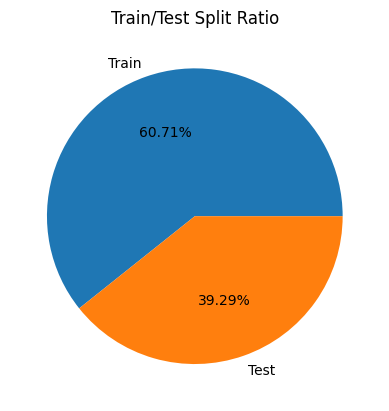

In [53]:
# # Check the proportion of training and testing samples
train_samples = len(X_train)
test_samples = len(X_test)

plt.pie([train_samples, test_samples], labels=['Train', 'Test'], autopct='%.2f%%')
plt.title('Train/Test Split Ratio')
plt.show()

## Scaling

In [54]:
# Data before scaling
X_train.head()

,flow_duration,Header_Length,Duration,Srate,rst_flag_number,psh_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,TCP,UDP,ICMP,LLC,Min,Max,Tot size,IAT,Variance
0,0.021024,760.700000,63.880000,2.714294,0.0,0.0,0.000000,0.050000,0.000000,0.000000,0.530000,1.0,0.0,0.0,1.0,378.800000,1479.800000,941.000000,8.334052e+07,0.950000
1,0.043902,11.096774,64.000000,1.255819,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,371.096774,1464.451613,931.612903,7.164235e+07,0.946237
2,0.000000,53.460000,63.360000,2390.976438,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,54.000000,54.840000,54.060000,8.294343e+07,0.140000
3,4.341755,9031.974874,64.729161,3.750398,0.0,0.0,0.104586,2.972546,0.494524,4.458862,9.268034,1.0,0.0,0.0,1.0,138.007313,1921.869600,816.123923,8.299921e+07,0.924586
4,0.000000,757.000000,63.360000,0.513484,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,1.0,388.200000,1502.600000,940.860000,8.333505e+07,0.950000


In [55]:
# X only has numeric columns
cols = X_train.columns

# Scale all numeric columns, using MinMaxScaler (range: 0 to 1)
scaler = MinMaxScaler()  
X_train[cols] = scaler.fit_transform(X_train[cols])  # Fit and transform the training data
X_test[cols] = scaler.transform(X_test[cols])        # Transform test data using the fitted scaler

In [56]:
# Data after scaling
X_train.head()

,flow_duration,Header_Length,Duration,Srate,rst_flag_number,psh_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,TCP,UDP,ICMP,LLC,Min,Max,Tot size,IAT,Variance
0,2.818729e-07,0.000077,0.250510,3.235691e-07,0.0,0.0,0.000000,0.004726,0.000000,0.000000,0.000059,1.0,0.0,0.0,1.0,0.077106,0.052215,0.118878,0.497142,0.950000
1,5.885992e-07,0.000001,0.250980,1.497053e-07,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,0.075343,0.051658,0.117636,0.427360,0.946237
2,0.000000e+00,0.000005,0.248471,2.850266e-04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.002747,0.000466,0.001595,0.494773,0.140000
3,5.821078e-05,0.000919,0.253840,4.470823e-07,0.0,0.0,0.020917,0.280959,0.006182,0.001078,0.001037,1.0,0.0,0.0,1.0,0.021980,0.068270,0.102365,0.495106,0.924586
4,0.000000e+00,0.000077,0.248471,6.121206e-08,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000056,0.0,0.0,0.0,1.0,0.079258,0.053043,0.118859,0.497109,0.950000


In [57]:
# Verify scaling 
print("Largest value in train set:", round(X_train.max().max(), 10))  
print("Smallest value in train set:", round(X_train.min().min(), 10))

Largest value in train set: 1.0
Smallest value in train set: 0.0


## Model Selection

In [58]:
# Evaluate model based on their performance metrics 
def evaluate_models(X, y, models):
    results = []
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    for name, model in models.items():
        scores = cross_validate(model, X, y, cv=3, scoring=scoring_metrics)        
        results.append({
            'Model': name,
            'Accuracy': round(scores['test_accuracy'].mean(), 5),
            'Precision': round(scores['test_precision'].mean(), 5),
            'Recall': round(scores['test_recall'].mean(), 5),
            'F1-score': round(scores['test_f1'].mean(), 5) ,
            'Fit Time(s)': round(scores['fit_time'].mean(), 3),
        })    
    return pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

In [59]:
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression

# Lightweight models to evaluate 
models_dict = {
    'LGBM': LGBMClassifier(max_depth=5, num_leaves=32, n_jobs=1, verbose=-1, random_state=30),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=30),
    'LDA': LinearDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=1000, random_state=30),
}

In [60]:
# Do a baseline comparison of all models
start_time = time.time()
model_results_df = evaluate_models(X_train, y_train, models_dict)

print("Time taken(s):", time.time() - start_time)
print(model_results_df)

Time taken(s): 166.17456531524658
                 Model  Accuracy  Precision   Recall  F1-score  Fit Time(s)
2        Decision Tree   0.99971    0.99981  0.99960   0.99971        2.690
0                 LGBM   0.99967    0.99953  0.99980   0.99967       11.357
4  Logistic Regression   0.75305    0.67117  0.99223   0.80071       33.463
3                  LDA   0.74835    0.66691  0.99230   0.79770        2.035
1          Naive Bayes   0.74139    0.66359  0.97941   0.79113        0.603


## Model Validation

In [61]:
import psutil
import platform

# Display CPU and RAM info in current environment (Kaggle notebook)
ram = psutil.virtual_memory()
print(f"CPU: {platform.processor() or 'Unknown'}")
print(f"Cores: {os.cpu_count()}")
print("\nMemory usage (RAM):")
!free -h

# List detailed info about the CPU
# print("\n\t(Detailed CPU Information)")
# !lscpu

CPU: x86_64
Cores: 4

Memory usage (RAM):
               total        used        free      shared  buff/cache   available
Mem:            31Gi        17Gi       7.7Gi       2.0Mi       6.2Gi        13Gi
Swap:             0B          0B          0B


In [62]:
print("Memory Usage of Training & Testing Sets (MB)\n")
print("\tTraining Features:", round(X_train.memory_usage(deep=True).sum() / (1024 ** 2), 2))
print("\tTesting Features:", round(X_test.memory_usage(deep=True).sum() / (1024 ** 2), 2))
print("\n\tTraining Labels:", round(y_train.memory_usage(deep=True) / (1024 ** 2), 2))
print("\tTesting Labels:", round(y_test.memory_usage(deep=True) / (1024 ** 2), 2))

Memory Usage of Training & Testing Sets (MB)

	Training Features: 222.77
	Testing Features: 144.16

	Training Labels: 11.14
	Testing Labels: 7.21


In [63]:
# Model selected (both models are single-threaded)
final_model = LGBMClassifier(max_depth=5, num_leaves=32, n_jobs=1, verbose=-1, random_state=30)
model_name = "LGBM"
# final_model = DecisionTreeClassifier(max_depth=5, random_state=30)
# model_name = "Decision Tree"

print("Model selected:", model_name)
print("Model parameters:\n", final_model.get_params())

Model selected: LGBM
Model parameters:
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'num_leaves': 32, 'objective': None, 'random_state': 30, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}


In [64]:
# Train the final model on training data 
start_time = time.time()
final_model.fit(X_train, y_train)
print(f"Training Time ({X_train.shape[0]} samples): {time.time() - start_time:.4f} seconds")

# Make predictions on test data using trained model
start_time = time.time()
y_pred = final_model.predict(X_test)
print(f"\nPrediction Time ({X_test.shape[0]} samples - Full Set): {time.time() - start_time:.4f} seconds")

# Prediction speed for 1000 samples
start_time = time.time()
_ = final_model.predict(X_test[:1000])
print(f"Prediction Time (1000 samples): {time.time() - start_time:.4f} seconds")

Training Time (1459934 samples): 16.2695 seconds

Prediction Time (944765 samples - Full Set): 2.9422 seconds
Prediction Time (1000 samples): 0.0061 seconds


In [65]:
from sklearn.metrics import classification_report

# Print performance metrics
print(f"(Classification report for {model_name})\n")
print(classification_report(y_test, y_pred, digits=5))

(Classification report for LGBM)

              precision    recall  f1-score   support

           0    0.99995   0.99958   0.99977    781251
           1    0.99801   0.99976   0.99888    163514

    accuracy                        0.99961    944765
   macro avg    0.99898   0.99967   0.99932    944765
weighted avg    0.99961   0.99961   0.99961    944765



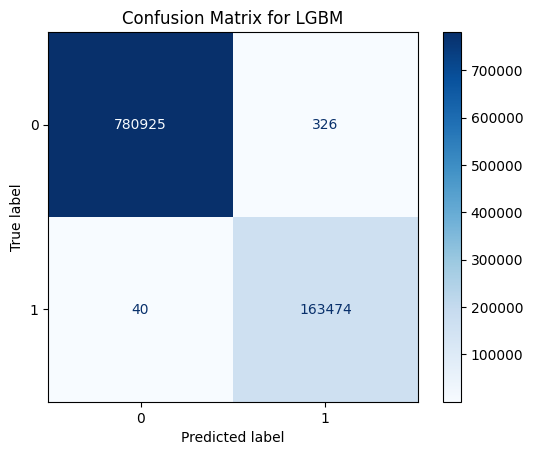

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create and display confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=final_model.classes_)
display.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

In [67]:
from mlxtend.evaluate import bias_variance_decomp

# Convert all inputs to numpy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Calculate the average bias, variance, expected loss
avg_loss, avg_bias, avg_var = bias_variance_decomp(final_model, X_train_np, y_train_np, X_test_np, y_test_np, 
                                                   loss='0-1_loss', num_rounds=50, random_seed=30)
print('Average bias: %.5f' % avg_bias)
print('Average variance: %.5f' % avg_var)
print('Average expected loss: %.5f' % avg_loss)
print('Goodness-of-Fit: %.5f' % (1 - avg_loss))

Average bias: 0.00037
Average variance: 0.00008
Average expected loss: 0.00039
Goodness-of-Fit: 0.99961


In [68]:
# Determine the most important feature
feature_names = X_train.columns 
important_feature = feature_names[np.argmax(final_model.feature_importances_)]
print(f"Most important feature for {model_name}:\n{important_feature}")

Most important feature for LGBM:
IAT


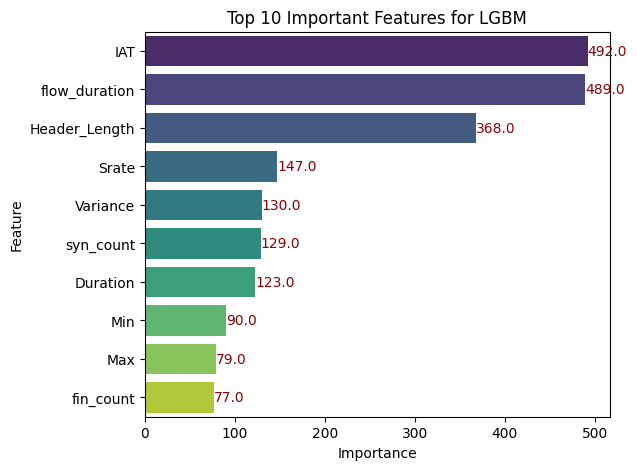

In [69]:
# Get feature importances
importances = final_model.feature_importances_
feature_names = X_train.columns 
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 features with highest importance
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette='viridis')
plt.title(f"Top 10 Important Features for {model_name}")

# Add value labels to bars
for i, v in enumerate(feat_imp_df.head(10)['Importance']):
    ax.text(v + 0.0001, i, f'{v:.1f}', color='darkred', va='center')
    
plt.show()

In [70]:
import joblib

# Saves model object to a file
model_files = {
    "Decision Tree": "dt.joblib",
    "LGBM": "lgbm.joblib"
}
if model_name in model_files:
    file_path = model_files[model_name]
    joblib.dump(final_model, file_path)
    !ls -lh {file_path}
else:
    print(f"Unknown model: {model_name}")

# To load trained model
# dt_loaded = joblib.load('dt.joblib')
# lgbm_loaded = joblib.load('lgbm.joblib')

-rw-r--r-- 1 root root 296K Jun 11 11:08 lgbm.joblib
